In [53]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 

from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import kendalltau, pearsonr, spearmanr
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle
import json

In [2]:
df = pd.read_csv('data_clean_final.csv')
df.head()

,customer_id,product_category,product_price,quantity,total_purchase_amount,payment_method,customer_age,returns,customer_name,age,gender,churn,date_of_purchase,time_of_purchase
0,30426,Books,399,1,4068,Credit Card,61,1.0,Aaron Alexander,61,Female,1,2020-10-12,22:26:27
1,10025,Home,66,1,1550,Credit Card,69,0.0,Aaron Bradley,69,Male,1,2021-03-17,16:36:31
2,4951,Clothing,210,4,4876,Cash,24,0.0,Aaron Carroll,24,Female,1,2021-06-30,02:56:03
3,41135,Clothing,54,4,2044,Cash,44,1.0,Aaron David,44,Female,1,2022-01-06,04:24:26
4,17580,Home,470,3,4705,Cash,67,1.0,Aaron Drake,67,Male,1,2022-05-18,21:46:44


In [3]:
df.tail()

,customer_id,product_category,product_price,quantity,total_purchase_amount,payment_method,customer_age,returns,customer_name,age,gender,churn,date_of_purchase,time_of_purchase
12917,31353,Books,389,1,5064,Crypto,19,0.0,Melanie Herrera,19,Male,0,2022-12-22,14:31:05
12918,29945,Clothing,324,2,2016,Credit Card,41,0.0,Anita Fowler,41,Female,0,2020-10-13,18:58:45
12919,16656,Clothing,417,3,981,PayPal,47,0.0,Margaret Cunningham,47,Female,0,2020-05-10,07:47:06
12920,8804,Books,220,1,195,Cash,23,0.0,Gregory Small,23,Male,0,2023-01-09,12:00:52
12921,23414,Home,172,4,2655,Credit Card,29,1.0,Sharon Reyes,29,Female,0,2023-08-10,11:36:37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12922 entries, 0 to 12921
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            12922 non-null  int64  
 1   product_category       12922 non-null  object 
 2   product_price          12922 non-null  int64  
 3   quantity               12922 non-null  int64  
 4   total_purchase_amount  12922 non-null  int64  
 5   payment_method         12922 non-null  object 
 6   customer_age           12922 non-null  int64  
 7   returns                12922 non-null  float64
 8   customer_name          12922 non-null  object 
 9   age                    12922 non-null  int64  
 10  gender                 12922 non-null  object 
 11  churn                  12922 non-null  int64  
 12  date_of_purchase       12922 non-null  object 
 13  time_of_purchase       12922 non-null  object 
dtypes: float64(1), int64(7), object(6)
memory usage: 1.4+ 

In [5]:
df[['date_of_purchase', 'time_of_purchase']] = df[['date_of_purchase', 'time_of_purchase']].apply(pd.to_datetime)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12922 entries, 0 to 12921
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   customer_id            12922 non-null  int64         
 1   product_category       12922 non-null  object        
 2   product_price          12922 non-null  int64         
 3   quantity               12922 non-null  int64         
 4   total_purchase_amount  12922 non-null  int64         
 5   payment_method         12922 non-null  object        
 6   customer_age           12922 non-null  int64         
 7   returns                12922 non-null  float64       
 8   customer_name          12922 non-null  object        
 9   age                    12922 non-null  int64         
 10  gender                 12922 non-null  object        
 11  churn                  12922 non-null  int64         
 12  date_of_purchase       12922 non-null  datetime64[ns]
 13  t

In [7]:
# cek duplikat data
print('Jumlah data yang terduplikat:', df.duplicated().sum())

Jumlah data yang terduplikat: 770


In [8]:
# remove data duplikat
df.drop_duplicates(inplace = True)

In [9]:
# cek duplikat data setelah di remove
print('Jumlah duplikat data setelah di remove:', df.duplicated().sum())
print('Jumlah data setelah remove duplikat:', len(df))

Jumlah duplikat data setelah di remove: 0
Jumlah data setelah remove duplikat: 12152


In [10]:
# cek missing value
df.isnull().sum()

customer_id              0
product_category         0
product_price            0
quantity                 0
total_purchase_amount    0
payment_method           0
customer_age             0
returns                  0
customer_name            0
age                      0
gender                   0
churn                    0
date_of_purchase         0
time_of_purchase         0
dtype: int64

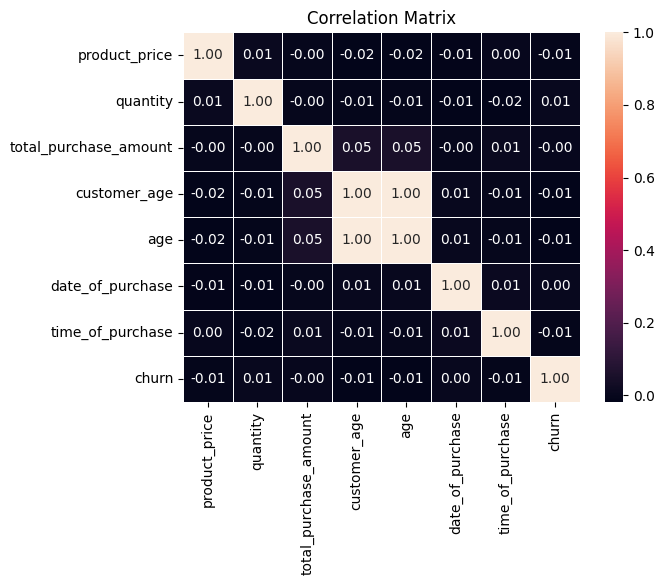

In [11]:
# list kolom yang akan diuji korelasinya
cols = ['product_price', 'quantity','total_purchase_amount', 'customer_age', 'age','date_of_purchase','time_of_purchase','churn']
# plot korelasi setiap variable menggunakan heatmap
sns.heatmap(df[cols].corr(), annot = True, fmt=".2f", linewidths=0.5)
# Memberikan judul
plt.title('Correlation Matrix')
# menampilkan correlation matrix
plt.show()

# Feature Engineering

In [12]:
# mendefinisikan kolom yang masuk ke tipe data kategorik dan dijadikan sebagai list
cat_cols = list(df.select_dtypes(include='object').columns)

# membuat list kosong listItem
listItem = []
# membuat forloop untuk kolom yang berada di dalam cat_cols
for col in cat_cols:
  # memasukkan nama kolom dan jumlah nilai unique pada list
  listItem.append([col, df[col].nunique(), df[col].unique()])

# membuat dataframe dari listItem
pd.DataFrame(columns=['Nama Kolom', 'Jumlah Nilai Unique', 'Nilai Unique'], data=listItem)

,Nama Kolom,Jumlah Nilai Unique,Nilai Unique
0,product_category,4,"[Books, Home, Clothing, Electronics]"
1,payment_method,4,"[Credit Card, Cash, Crypto, PayPal]"
2,customer_name,12152,"[Aaron Alexander, Aaron Bradley, Aaron Carroll..."
3,gender,2,"[Female, Male]"


customer_name perlu di drop

In [13]:
# Cek apakah target balance atau tidak
df['churn'].value_counts()

churn
1    6461
0    5691
Name: count, dtype: int64

In [14]:
#memisahkan antara fitur x dan y
X = df.drop(['churn'], axis = 1)
y = df['churn']

In [15]:
# split data menjadi train set, val set, dan test set
X_train,X_test1,y_train,y_test1 = train_test_split(X,y,test_size=0.3,shuffle=True,random_state=64,stratify=y)
X_val, X_test, y_val, y_test  = train_test_split(X_test1,y_test1,test_size=0.5,shuffle=True,random_state=64)

print(f'X_train:{X_train.shape}')
print(f'X_test:{X_test.shape}')
print(f'X_val:{X_val.shape}')
print('')
print(f'y_train:{y_train.shape}')
print(f'y_test:{y_test.shape}')
print(f'y_val:{y_val.shape}')

X_train:(8506, 13)
X_test:(1823, 13)
X_val:(1823, 13)

y_train:(8506,)
y_test:(1823,)
y_val:(1823,)


# Handling Outliers

In [16]:
# Mendefinisikan kolom numerik dari X_train
num_train = X_train._get_numeric_data()
# Looping key dataframe k nama kolom dan v data numerik dari kolom
for k, v in num_train.items():
  # kuantil ke-1
  q1 = v.quantile(0.25)
  # kuantil ke-3
  q3 = v.quantile(0.75)
  # Rentang interkuantil dari kolom v
  iqr = q3 - q1
  # Mendefinisikan kolom v untuk nilai di luar batas atas dan batas bawah
  v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
  # Persentase jumlah outlier dalam kolom v terhadap jumlah total baris dalam DataFrame
  perc = np.shape(v_col)[0] * 100.0 / np.shape(num_train)[0]
  # Menampilkan nilai outliers
  print("Column %s outliers = %.2f%%" % (k, perc))

Column customer_id outliers = 0.00%
Column product_price outliers = 0.00%
Column quantity outliers = 0.00%
Column total_purchase_amount outliers = 0.00%
Column customer_age outliers = 0.00%
Column returns outliers = 0.00%
Column age outliers = 0.00%


# Handling Missing Value

In [17]:
X_train.isnull().sum()

customer_id              0
product_category         0
product_price            0
quantity                 0
total_purchase_amount    0
payment_method           0
customer_age             0
returns                  0
customer_name            0
age                      0
gender                   0
date_of_purchase         0
time_of_purchase         0
dtype: int64

In [18]:
X_val.isnull().sum()

customer_id              0
product_category         0
product_price            0
quantity                 0
total_purchase_amount    0
payment_method           0
customer_age             0
returns                  0
customer_name            0
age                      0
gender                   0
date_of_purchase         0
time_of_purchase         0
dtype: int64

In [19]:
X_test.isnull().sum()

customer_id              0
product_category         0
product_price            0
quantity                 0
total_purchase_amount    0
payment_method           0
customer_age             0
returns                  0
customer_name            0
age                      0
gender                   0
date_of_purchase         0
time_of_purchase         0
dtype: int64

# Feature Selection

In [20]:
# Drop Columns
X_train.drop(['customer_id', 'customer_name', 'age'], axis=1, inplace=True)
X_val.drop(['customer_id', 'customer_name', 'age'], axis=1, inplace=True)
X_test.drop(['customer_id', 'customer_name', 'age'], axis=1, inplace=True)

In [21]:
X_train.head()

,product_category,product_price,quantity,total_purchase_amount,payment_method,customer_age,returns,gender,date_of_purchase,time_of_purchase
9950,Clothing,316,2,3315,Cash,34,1.0,Female,2023-02-11,2024-02-04 18:39:13
11156,Electronics,46,2,4067,Credit Card,66,1.0,Male,2021-08-05,2024-02-04 03:31:30
5727,Clothing,173,3,1742,PayPal,67,0.0,Female,2021-09-26,2024-02-04 21:53:48
4966,Clothing,257,4,4629,Credit Card,18,0.0,Female,2021-05-31,2024-02-04 00:03:40
1391,Electronics,54,1,4269,Credit Card,36,0.0,Male,2020-11-13,2024-02-04 13:20:34


In [22]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8506 entries, 9950 to 2399
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   product_category       8506 non-null   object        
 1   product_price          8506 non-null   int64         
 2   quantity               8506 non-null   int64         
 3   total_purchase_amount  8506 non-null   int64         
 4   payment_method         8506 non-null   object        
 5   customer_age           8506 non-null   int64         
 6   returns                8506 non-null   float64       
 7   gender                 8506 non-null   object        
 8   date_of_purchase       8506 non-null   datetime64[ns]
 9   time_of_purchase       8506 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(4), object(3)
memory usage: 731.0+ KB


In [23]:
# Mendefinisikan kolom data numerik dan data kategorik 
num_columns = X_train.select_dtypes(include=np.number).columns.tolist()
# num_columns = ['product_price', 'quantity', 'total_purchase_amount', 'customer_age', 'returns', 'date_of_purchase', 'time_of_purchase']
cat_columns = list(X_train.select_dtypes(include='object').columns)
# cat_columns = ['product_category', 'payment_method', 'gender', 'date_of_purchase', 'time_of_purchase']

# menampilkan list kolom numerik dan kolom kategorik
print('Numeric Columns: ', num_columns)
print('Categorical Columns: ', cat_columns)

Numeric Columns:  ['product_price', 'quantity', 'total_purchase_amount', 'customer_age', 'returns']
Categorical Columns:  ['product_category', 'payment_method', 'gender']


In [24]:
# Split kolom numerik dan kolom kategorik pada dataset train dan test
X_train_num = X_train[num_columns]
X_train_cat = X_train[cat_columns]

X_test_num = X_test[num_columns]
X_test_cat = X_test[cat_columns]

X_val_num = X_val[num_columns]
X_val_cat = X_val[cat_columns]

# menampilkan dataset train numerik
print('X_train_num:', X_train_num.shape)
print('X_test_num:', X_test_num.shape)
print('X_val_num:', X_val_num.shape)
print('')
print('X_train_cat:', X_train_cat.shape)
print('X_test_cat:', X_test_cat.shape)
print('X_val_cat:', X_val_cat.shape)

X_train_num: (8506, 5)
X_test_num: (1823, 5)
X_val_num: (1823, 5)

X_train_cat: (8506, 3)
X_test_cat: (1823, 3)
X_val_cat: (1823, 3)


# Uji Korelasi

In [25]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# melakukan forloop untuk kolom yang terdapat didalam dataset kategorik
for col in X_train_cat.columns:
  # melakukan uji korelasi dengan menggunakan kendaltau pada setiap kolom dataset kategorik
  corr_coef, p_value = kendalltau(X_train_cat[col], y_train)

  #input p_values ke dalam list p_values
  p_values.append(p_value)
  # input nama kolom ke list cols
  cols.append(col)

  # dilakukan pengecekan, jika p_value di bawah nilai 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat Korelasi')
  # jika p_value berada di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk nama kolom dan hasil dari interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,product_category,Tidak terdapat korelasi
1,payment_method,Tidak terdapat korelasi
2,gender,Tidak terdapat korelasi


In [26]:
# Mendefinisikan list kosong untuk p_values, interpretasi, dan cols
p_values = []
interpretasi = []
cols = []

# forloop untuk kolom yang berada di dataset numerik
for col in X_train_num.columns:
  # melakukan perhitungan uji korelasi dengan menggunakan pearsonr untuk data numerik
  corr_coef, p_value = spearmanr(X_train_num[col], y_train)

  # p_value yang didapat kemudian dimasukkan ke dalam list p_value
  p_values.append(p_value)
  # memasukkan nama dari setiap kolom numerik
  cols.append(col)

  # cek jika p_value di bawah 0.05, maka terdapat korelasi
  if p_value < 0.05:
    interpretasi.append('Terdapat korelasi')
  # jika p_value di atas nilai 0.05, maka tidak terdapat korelasi
  else :
    interpretasi.append('Tidak terdapat korelasi')

# membuat dataframe untuk kolom han hasil interpretasi
pd.DataFrame({'nama kolom':cols,
              'hasil': interpretasi})

,nama kolom,hasil
0,product_price,Tidak terdapat korelasi
1,quantity,Tidak terdapat korelasi
2,total_purchase_amount,Tidak terdapat korelasi
3,customer_age,Tidak terdapat korelasi
4,returns,Tidak terdapat korelasi


In [27]:
# Create A Pipeline

num_pipeline = make_pipeline(StandardScaler())

cat_pipeline = make_pipeline(OneHotEncoder())

final_pipeline = ColumnTransformer([
    ('pipe_num', num_pipeline, num_columns),
    ('pipe_cat', cat_pipeline, cat_columns)
])

In [28]:
# Fit and Transform

X_train = final_pipeline.fit_transform(X_train)
X_val = final_pipeline.transform(X_val)
X_test = final_pipeline.transform(X_test)

In [33]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
X_val = pd.DataFrame(X_val)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.420179,-0.698001,0.410466,-0.624241,0.986918,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,-1.502529,-0.698001,0.933600,1.438640,0.986918,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-0.598144,0.004626,-0.683802,1.503105,-1.013255,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,0.000032,0.707253,1.324559,-1.655681,-1.013255,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,-1.445559,-1.400628,1.074122,-0.495311,-1.013255,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [47]:
# Membuat pipeline untuk logistic regression
pipe_logreg = Pipeline([
    ('classifier', LogisticRegression())
])

#Membuat pipeline untuk SVM
pipe_svc = Pipeline([
('classifier', SVC())
])

#Membuat pipeline untuk KNN
pipe_knn = Pipeline([
('classifier', KNeighborsClassifier())
])

#Membuat pipeline untuk Random Forest   
pipe_rf = Pipeline([
('classifier', RandomForestClassifier())
])

#Membuat pipeline untuk Decision Tree
pipe_dt = Pipeline([
('classifier', DecisionTreeClassifier())
])

In [38]:
# fit model pada train set
pipe_logreg.fit(X_train, y_train)
# predict model pada val set
y_logreg_pred = pipe_logreg.predict(X_val)
# predict model pada test set
y_logreg_pred = pipe_logreg.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(pipe_logreg.score(X_train, y_train),4))
print('Val Score: ', round(pipe_logreg.score(X_val, y_val),4))
print('Testing Score: ', round(pipe_logreg.score(X_test, y_test),4))

Training Score:  0.5334
Val Score:  0.5376
Testing Score:  0.5277


In [40]:
# # Mendefinisikan target
# target = ['No', 'Yes']
# menampilkan classification report
print(classification_report(y_test, y_logreg_pred))

              precision    recall  f1-score   support

           0       0.58      0.03      0.05       868
           1       0.53      0.98      0.69       955

    accuracy                           0.53      1823
   macro avg       0.55      0.50      0.37      1823
weighted avg       0.55      0.53      0.39      1823



In [41]:
# fit model pada train set
pipe_svc.fit(X_train, y_train)
# predict model pada val set
y_svc_pred = pipe_svc.predict(X_val)
# predict model pada test set
y_svc_pred = pipe_svc.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(pipe_svc.score(X_train, y_train),4))
print('Val Score: ', round(pipe_svc.score(X_val, y_val),4))
print('Testing Score: ', round(pipe_svc.score(X_test, y_test),4))

Training Score:  0.5896
Val Score:  0.5272
Testing Score:  0.5288


In [42]:
# menampilkan classification report
print(classification_report(y_test, y_svc_pred))

              precision    recall  f1-score   support

           0       0.51      0.23      0.32       868
           1       0.53      0.80      0.64       955

    accuracy                           0.53      1823
   macro avg       0.52      0.52      0.48      1823
weighted avg       0.52      0.53      0.49      1823



In [44]:
# fit model pada train set
pipe_knn.fit(X_train, y_train)
# predict model pada val set
y_knn_pred = pipe_knn.predict(X_val)
# predict model pada test set
y_knn_pred = pipe_knn.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(pipe_knn.score(X_train, y_train),4))
print('Val Score: ', round(pipe_knn.score(X_val, y_val),4))
print('Testing Score: ', round(pipe_knn.score(X_test, y_test),4))

Training Score:  0.689
Val Score:  0.492
Testing Score:  0.5112


In [45]:
# menampilkan classification report
print(classification_report(y_test, y_knn_pred))

              precision    recall  f1-score   support

           0       0.49      0.46      0.47       868
           1       0.53      0.56      0.54       955

    accuracy                           0.51      1823
   macro avg       0.51      0.51      0.51      1823
weighted avg       0.51      0.51      0.51      1823



In [48]:
# fit model pada train set
pipe_rf.fit(X_train, y_train)
# predict model pada val set
y_rf_pred = pipe_rf.predict(X_val)
# predict model pada test set
y_rf_pred = pipe_rf.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(pipe_rf.score(X_train, y_train),4))
print('Val Score: ', round(pipe_rf.score(X_val, y_val),4))
print('Testing Score: ', round(pipe_rf.score(X_test, y_test),4))

Training Score:  1.0
Val Score:  0.5112
Testing Score:  0.503


In [49]:
# menampilkan classification report
print(classification_report(y_test, y_rf_pred))

              precision    recall  f1-score   support

           0       0.48      0.42      0.45       868
           1       0.52      0.58      0.55       955

    accuracy                           0.50      1823
   macro avg       0.50      0.50      0.50      1823
weighted avg       0.50      0.50      0.50      1823



In [50]:
# fit model pada train set
pipe_dt.fit(X_train, y_train)
# predict model pada val set
y_dt_pred = pipe_dt.predict(X_val)
# predict model pada test set
y_dt_pred = pipe_dt.predict(X_test)
# Menampilkan nilai akurasi training dan testing
print('Training Score: ',round(pipe_dt.score(X_train, y_train),4))
print('Val Score: ', round(pipe_dt.score(X_val, y_val),4))
print('Testing Score: ', round(pipe_dt.score(X_test, y_test),4))

Training Score:  1.0
Val Score:  0.4931
Testing Score:  0.5003


In [51]:
# menampilkan classification report
print(classification_report(y_test, y_dt_pred))

              precision    recall  f1-score   support

           0       0.48      0.49      0.48       868
           1       0.52      0.51      0.52       955

    accuracy                           0.50      1823
   macro avg       0.50      0.50      0.50      1823
weighted avg       0.50      0.50      0.50      1823



In [52]:
param_knn = {
    'classifier__n_neighbors': np.arange(2, 30, 1), 
    'classifier__weights': ['uniform', 'distance']  
}
param_dt = {
    'classifier__criterion': ['gini', 'entropy'],
    'classifier__max_depth': [5, 10, 15, 20],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__ccp_alpha': [0.0, 0.1, 0.2]
}

param_rf = {
    'classifier__n_estimators': np.arange(200, 401, 30),
    'classifier__max_depth': np.arange(4, 8, 2) }

In [54]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [63]:
# proses grid search untuk tuning hyperparameter secara paralel
grid_knn = GridSearchCV(pipe_knn, param_grid=param_knn, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [64]:
# proses grid search untuk tuning hyperparameter secara paralel
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [65]:
# proses grid search untuk tuning hyperparameter secara paralel
grid_dt = GridSearchCV(pipe_dt, param_grid=param_dt, cv=stratified_kfold, n_jobs=-1).fit(X_train, y_train)

In [72]:
# Menampilkan hasil train dan test setelah dilakukan tuning
print('Train Set Score : ', grid_knn.score(X_train, y_train))
print('val Set Score : ', grid_knn.score(X_val, y_val))
print('Test Set Score : ', grid_knn.score(X_test, y_test))

Train Set Score :  0.5904067716905713
val Set Score :  0.5167306637410861
Test Set Score :  0.49917718047174986


In [73]:
# Menampilkan hasil train dan test setelah dilakukan tuning
print('Train Set Score : ', grid_rf.score(X_train, y_train))
print('val Set Score : ', grid_rf.score(X_val, y_val))
print('Test Set Score : ', grid_rf.score(X_test, y_test))

Train Set Score :  0.5797084411003998
val Set Score :  0.5298957761930884
Test Set Score :  0.526055951727921


In [74]:
# Menampilkan hasil train dan test setelah dilakukan tuning
print('Train Set Score : ', grid_dt.score(X_train, y_train))
print('val Set Score : ', grid_dt.score(X_val, y_val))
print('Test Set Score : ', grid_dt.score(X_test, y_test))

Train Set Score :  0.5316247354808371
val Set Score :  0.5397696105320899
Test Set Score :  0.523861766319254


In [57]:
# Mendefinisikan parameter yang terbaik
best_param_knn = grid_knn.best_params_
# Menampilkan best parameter
print(best_param_knn)
print('\n')
# mendefinsiikan estimator yang terbaik
best_pipe_knn = grid_knn.best_estimator_
# menampilkan estimator yang terbaik
print(best_pipe_knn)
print('\n')
# Membuat dataframe untuk result_df_knn
result_df_knn = pd.DataFrame.from_dict(grid_knn.cv_results_, orient='columns')
# menampilkan kolom result_df_knn
print(result_df_knn.columns)

{'classifier__n_neighbors': 25, 'classifier__weights': 'uniform'}


Pipeline(steps=[('classifier', KNeighborsClassifier(n_neighbors=25))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__n_neighbors', 'param_classifier__weights', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


In [68]:
# Mendefinisikan parameter yang terbaik
best_param_rf = grid_rf.best_params_
# Menampilkan best parameter
print(best_param_rf)
print('\n')
# mendefinsiikan estimator yang terbaik
best_pipe_rf = grid_rf.best_estimator_
# menampilkan estimator yang terbaik
print(best_pipe_rf)
print('\n')
# Membuat dataframe untuk result_df_rf
result_df_rf = pd.DataFrame.from_dict(grid_rf.cv_results_, orient='columns')
# menampilkan kolom result_df_rf
print(result_df_rf.columns)

{'classifier__max_depth': 6, 'classifier__n_estimators': 230}


Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=6, n_estimators=230))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__max_depth', 'param_classifier__n_estimators',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


In [69]:
# Mendefinisikan parameter yang terbaik
best_param_dt = grid_dt.best_params_
# Menampilkan best parameter
print(best_param_dt)
print('\n')
# mendefinsiikan estimator yang terbaik
best_pipe_dt = grid_dt.best_estimator_
# menampilkan estimator yang terbaik
print(best_pipe_dt)
print('\n')
# Membuat dataframe untuk result_df_dt
result_df_dt = pd.DataFrame.from_dict(grid_dt.cv_results_, orient='columns')
# menampilkan kolom result_df_dt
print(result_df_dt.columns)

{'classifier__ccp_alpha': 0.1, 'classifier__criterion': 'gini', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 1}


Pipeline(steps=[('classifier',
                 DecisionTreeClassifier(ccp_alpha=0.1, max_depth=5))])


Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__ccp_alpha', 'param_classifier__criterion',
       'param_classifier__max_depth', 'param_classifier__min_samples_leaf',
       'params', 'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')


In [59]:
print(classification_report(y_test, best_pipe_knn.predict(X_test)))

              precision    recall  f1-score   support

           0       0.47      0.36      0.41       868
           1       0.52      0.62      0.57       955

    accuracy                           0.50      1823
   macro avg       0.49      0.49      0.49      1823
weighted avg       0.49      0.50      0.49      1823



In [70]:
print(classification_report(y_test, best_pipe_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.05      0.10       868
           1       0.53      0.95      0.68       955

    accuracy                           0.53      1823
   macro avg       0.52      0.50      0.39      1823
weighted avg       0.52      0.53      0.40      1823



In [71]:
print(classification_report(y_test, best_pipe_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       868
           1       0.52      1.00      0.69       955

    accuracy                           0.52      1823
   macro avg       0.26      0.50      0.34      1823
weighted avg       0.27      0.52      0.36      1823

